## Setup

In [1]:
!pip install numpy
!pip install pandas
!pip install scipy
!pip install hmmlearn
!pip install statsmodels

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
import gzip
import os
from tqdm import tqdm
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import fisher_exact
import math
import joblib
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [6]:
# Specify project directories in Sherlock
data_path = '/oak/stanford/groups/mrivas/projects/wgs-constraint-llm/data/'
results_path = '/oak/stanford/groups/mrivas/projects/wgs-constraint-llm/osthoag/wgs-constraint-llm/results/'

# Specify the file paths
aou_variants_file_path = data_path + 'aou_variants.tsv.gz'
genome_coverage_file_path = data_path + 'gnomad.genomes.r3.0.1.coverage.summary.tsv.bgz'

## Define helper methods

In [8]:
# Function to calculate the proportion of each row that overlaps with an array of positions
def calculate_overlap(row, positions, start_col='start', end_col='end'):
    return np.sum((row[start_col] <= positions) & (positions <= row[end_col])) / (row[end_col] - row[start_col] + 1)

def get_sequence(coverage_df, variants_df):
    # Get the length of the genetic sequence
    sequence_length = max(coverage_df['pos'].max(), variants_df['pos'].max())

    # Create boolean mask for exome coverage
    coverage_mask = np.zeros(sequence_length + 1, dtype=bool)

    # Use NumPy boolean indexing to get mask for positions with over 80% coverage
    coverage_mask[coverage_df['pos'].to_numpy()] = 1

    # Initialize values to zero for all positions
    sequence = np.zeros(sequence_length + 1)

    # Set positions to 1 where a variant exists
    sequence[variants_df['pos'].to_numpy()] = 1

    # Filter for only the protein-coding regions with over 80% exome coverage
    observations = np.array(sequence[coverage_mask])
    
    positions = np.where(coverage_mask)[0]
    
    return observations, positions

def get_HMM_predictions(observations, model, order=2):
    # Flatten the higher-order structure
    X = np.stack([observations[i:i-order] for i in range(order)], axis=1)

    # Convert observations to counts
    X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])

    # Predict probabilities for each position
    probabilities = model.predict_proba(X_counts)

    return probabilities

def fit_HMM(observations, order=2):
    # Flatten the higher-order structure
    X = np.stack([observations[i:i-order] for i in range(order)], axis=1)

    # Convert observations to counts
    X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])

    # Create and fit a first-order HMM
    model = hmm.MultinomialHMM(n_components=2, random_state=10)
    model.fit(X_counts)

    return model

def fit_and_predict_HMM(observations, order=2):
    # Flatten the higher-order structure
    X = np.stack([observations[i:i-order] for i in range(order)], axis=1)

    # Convert observations to counts
    X_counts = np.column_stack([(X == i).sum(axis=1) for i in range(2)])

    # Create and fit a first-order HMM
    model = hmm.MultinomialHMM(n_components=2, random_state=10)
    model.fit(X_counts)

    # Predict probabilities for each position
    probabilities = model.predict_proba(X_counts)

    return probabilities

def ols_regression(predictions_df):
    # Add a constant term to the independent variable for the intercept
    X = sm.add_constant(predictions_df['prob_0'])

    # Fit the linear regression model
    model4 = sm.OLS(predictions_df['observation'],X).fit()

    model4.summary().tables[1].pvalues_precision = 100  # Adjust the number of significant digits

    # Get the summary of the regression
    print(model4.summary())

    # Extract the F-statistic and its associated p-value
    f_statistic = model4.fvalue
    p_value_f_statistic = model4.f_pvalue
    
    return f_statistic, p_value_f_statistic

def fishers_exact_test(gene_id, ac_case, an_case, ac_ctrl, an_ctrl):
    if any((value < 0) or (math.isnan(value)) for value in [ac_case, an_case - ac_case, ac_ctrl, an_ctrl - ac_ctrl]):
        print(f"Negative values detected: gene={gene_id}, ac_case={ac_case}, an_case={an_case}, ac_ctrl={ac_ctrl}, an_ctrl={an_ctrl}")
        return None, None

    contingency_table = [[ac_case, an_case - ac_case], [ac_ctrl, an_ctrl - ac_ctrl]]
    odds_ratio, p_value = fisher_exact(contingency_table)
    return odds_ratio, p_value

def apply_fishers_exact_test(cases_df):
    # Apply only to the pLoFs
    cases_df = cases_df[cases_df['consequence'] == 'pLoF']
    
    # Calculate total counts for cases and controls
    cases_df['total_ac_case'] = cases_df.groupby(['gene_id', 'group'])['ac_case'].transform('sum')
    cases_df['total_an_case'] = cases_df.groupby(['gene_id', 'group'])['an_case'].transform('max')
    cases_df['total_ac_ctrl'] = cases_df.groupby(['gene_id', 'group'])['ac_ctrl'].transform('sum')
    cases_df['total_an_ctrl'] = cases_df.groupby(['gene_id', 'group'])['an_ctrl'].transform('max')

    # Remove duplicate rows for unique combinations of 'gene_id' and 'group'
    unique_cases_df = cases_df[['gene_id', 'gene_name', 'group', 'total_ac_case', 'total_an_case', 'total_ac_ctrl', 'total_an_ctrl']].drop_duplicates()

    # Drop Nan values from gene_id
    unique_cases_df = unique_cases_df.dropna(subset=['gene_id'])

    # Apply Fisher's exact test for each unique combination
    unique_cases_df[['odds_ratio', 'p_value']] = unique_cases_df.apply(lambda row: fishers_exact_test(row['gene_id'],row['total_ac_case'], row['total_an_case'], row['total_ac_ctrl'], row['total_an_ctrl']), axis=1, result_type='expand')

    # Sort the DataFrame by 'p_value' in increasing order
    sorted_df = unique_cases_df.sort_values(by='p_value')
    
    return sorted_df
    
from scipy.stats import chi2
def fisher_method_p_value(p_values):
    """
    Combine p-values using Fisher's method.

    Parameters:
    - p_values: List of p-values to be combined.

    Returns:
    - Combined p-value.
    """
    if len(p_values) < 2:
        raise ValueError("At least two p-values are required for Fisher's method.")
        
    # Drop NaN values
    p_values = p_values[~np.isnan(p_values)]

    # Convert p-values to chi-squared statistics
    chi_squared_stats = -2 * np.log(p_values)

    # Sum of chi-squared statistics
    chi_squared_sum = np.sum(chi_squared_stats)

    # Degrees of freedom for the chi-squared distribution
    degrees_of_freedom = 2 * len(p_values)

    # Combined p-value using chi-squared distribution
    combined_p_value = 1 - chi2.cdf(chi_squared_sum, degrees_of_freedom)

    return combined_p_value

def plot_hist_from_predictions(predictions_df):
    # Create a figure with two subplots in one row and two columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the first histogram in the first subplot
    axs[0].hist(predictions_df['observation'], edgecolor="blue")
    axs[0].set_title('Histogram of Observations')
    axs[0].set_xlabel('Has a variant')
    axs[0].set_ylabel('Frequency')

    # Plot the second histogram in the second subplot
    axs[1].hist(predictions_df['prob_0'], edgecolor="blue")
    axs[1].set_title('Histogram of Predictions')
    axs[1].set_xlabel('Probability of 0')
    axs[1].set_ylabel('Frequency')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Show the plots
    plt.show()

## Load data

In [9]:
# Initialize an empty dataframe to store the concatenated data
aou_variants_df = pd.DataFrame()

# Check if the joined file already exists
if not os.path.exists(aou_variants_file_path):
    # Loop through chromosomes and append dataframes with tqdm
    for filenum in tqdm(range(1, 9), desc='Processing Files'):
        # Read the variants file into a pandas DataFrame
        file_variants_df = pd.read_csv(
            data_path + "output_prefix_0" + str(filenum) + ".tsv.gz",
            sep='-',
            skiprows=1,
            usecols=[0,1],
            names=['chr', 'pos'],
            dtype={'chr': str, 'pos': int},
        )
        
        file_variants_df.drop_duplicates(inplace=True)

        # Append the dataframe to the main dataframe
        aou_variants_df = pd.concat([aou_variants_df, file_variants_df], ignore_index=True)
    
    # Add chr prefix for consistency
    aou_variants_df['chr'] = 'chr' + aou_variants_df['chr'].astype(str)
    
    # Write aou_variants_df to a csv to avoid recomputing
    aou_variants_df.to_csv(aou_variants_file_path, index=False, compression='gzip', sep='\t')
    
else:
    # Read the file into a pandas DataFrame
    aou_variants_df = pd.read_csv(aou_variants_file_path, sep='\t')

aou_variants_df

,chr,pos
0,chr1,10001
1,chr1,10073
2,chr1,10108
3,chr1,10110
4,chr1,10113
...,...,...
934655699,chrY,56887741
934655700,chrY,56887744
934655701,chrY,56887793
934655702,chrY,56887802


## Train HMM on AoU chromosome 2 and get predictions for full genome

In [13]:
# Define coverage filter
# coverage_filter = '0.5_over10' # coverage['over10'] > 0.5
coverage_filter = '0.9_over20' # coverage['over20'] > 0.9

# Define pattern for coverage file paths
# coverage_file_prefix = data_path + 'gnomad.genomes.r3.0.1.coverage_0.5_over10_chr'
coverage_file_prefix = data_path + 'gnomad_r3_coverage/' + 'gnomad.genomes.r3.0.1.coverage_' + coverage_filter + '_chr'
coverage_file_suffix = '.summary.tsv.gz'

# Parameters for analysis
order = 2

# Define model name (and absolute path)
model_name = results_path + 'HMM_aou_' + coverage_filter + '_chr2'

# Define path to trained HMM
hmm_file_path = model_name + '_model.joblib'

if os.path.exists(hmm_file_path):
    # Load the pretrained model
    model = joblib.load(hmm_file_path)
    
else:
    # Filter rows for chromosome 2
    chr_variants_df = aou_variants_df[aou_variants_df['chr'] == 'chr2']
    chr_coverage_df = pd.read_csv(coverage_file_prefix + '2' + coverage_file_suffix, sep='\t', names=['pos'])

    # Get training data for the chromosome
    observations, positions = get_sequence(chr_coverage_df, chr_variants_df)

    # Fit HMM to Chromosome 2
    model = fit_HMM(observations, order=order)

    # Save the HMM model to a file to avoid retraining
    joblib.dump(model, hmm_file_path)

----------------------------------------------------------------------------------------------------
PROCESSING CHROMOSOME 19


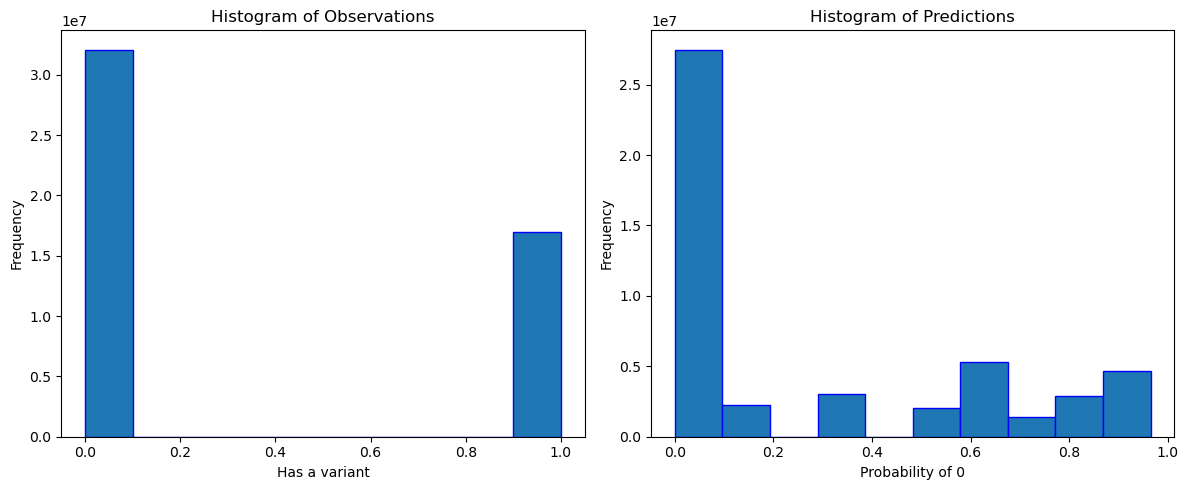

                            OLS Regression Results                            
Dep. Variable:            observation   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                 2.238e+07
Date:                Mon, 19 Feb 2024   Prob (F-statistic):               0.00
Time:                        16:30:03   Log-Likelihood:            -2.3935e+07
No. Observations:            49047423   AIC:                         4.787e+07
Df Residuals:                49047421   BIC:                         4.787e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5527   7.13e-05   7756.290      0.0

,chr,pos,prob_0,prob_1,observation
0,chr19,80813,9.375901e-35,1.000000,0.0
1,chr19,80814,6.576426e-01,0.342357,0.0
2,chr19,80815,8.672249e-01,0.132775,0.0
3,chr19,80816,9.340162e-01,0.065984,0.0
4,chr19,80817,9.553017e-01,0.044698,0.0
...,...,...,...,...,...
49047418,chr19,58605004,1.016501e-02,0.989835,1.0
49047419,chr19,58605005,6.393034e-01,0.360697,0.0
49047420,chr19,58605006,8.335699e-01,0.166430,0.0
49047421,chr19,58605007,8.759250e-01,0.124075,0.0


In [15]:
# for chromnum in range(1,23):
for chromnum in [19,]:
    print('-'*100)
    print("PROCESSING CHROMOSOME", str(chromnum))

    # Filter rows for given chromosome
    chr_variants_df = aou_variants_df[aou_variants_df['chr'] == 'chr' + str(chromnum)]
    chr_coverage_df = pd.read_csv(coverage_file_prefix + str(chromnum) + coverage_file_suffix, sep='\t', names=['pos'])
    
    # Get training data for the chromosome
    observations, positions = get_sequence(chr_coverage_df, chr_variants_df)

    # Fit HMM and retrieve probabilites
    probabilities = get_HMM_predictions(observations, model, order=order)
    
    # Create a DataFrame with 'pos' reflecting the index of the original sequence and 'prob_0/1' as the predictions
    chr_predictions_df = pd.DataFrame({'chr': 'chr' + str(chromnum),
                                       'pos': positions[0:-order],
                                       'prob_0': probabilities[:, 0], 
                                       'prob_1': probabilities[:, 1], 
                                       'observation': observations[0:-order]
                                      })
    
    predictions_file_prefix = model_name + "_predictions_aou_chr"
    
    # Checkpoint chr_predictions_df to a csv to avoid memory bottleneck
    chr_predictions_df.to_csv(predictions_file_prefix + str(chromnum) + ".tsv.gz", index=False, compression='gzip', sep='\t')
    
    # Plot histograms for predicted vs observed variants
    plot_hist_from_predictions(chr_predictions_df)
    
    # Run regression
    f_statistic, p_value_f_statistic = ols_regression(chr_predictions_df)
    
chr_predictions_df

## Get predictions for AoU chromosome 19 from the HMM trained on UKB chromosome 19

In [16]:
# Define coverage filter
# coverage_filter = '0.5_over10' # coverage['over10'] > 0.5
coverage_filter = '0.9_over20' # coverage['over20'] > 0.9

# Define pattern for coverage file paths
# coverage_file_prefix = data_path + 'gnomad.genomes.r3.0.1.coverage_0.5_over10_chr'
coverage_file_prefix = data_path + 'gnomad_r3_coverage/' + 'gnomad.genomes.r3.0.1.coverage_' + coverage_filter + '_chr'
coverage_file_suffix = '.summary.tsv.gz'

# Parameters for analysis
order = 2

# Define model name (and absolute path)
model_name = results_path + 'HMM_ukb_' + coverage_filter + '_chr19'

# Load the pretrained model
model = joblib.load(model_name + '_model.joblib')

# Get coverage file for chromosome 19
chr19_coverage_df = pd.read_csv(coverage_file_prefix + '19' + coverage_file_suffix, sep='\t', names=['pos'])

chr19_coverage_df

,pos
0,80813
1,80814
2,80815
3,80816
4,80817
...,...
49047420,58605006
49047421,58605007
49047422,58605008
49047423,58605009


In [19]:
chr_variants_df = aou_variants_df[aou_variants_df['chr'] == 'chr' + str(chromnum)]

# Get training data for the chromosome
observations, positions = get_sequence(chr_coverage_df, chr_variants_df)

# Fit HMM and retrieve probabilites
probabilities = get_HMM_predictions(observations, model, order=order)

# Create a DataFrame with 'pos' reflecting the index of the original sequence and 'prob_0/1' as the predictions
chr_predictions_df = pd.DataFrame({'chr': 'chr19',
                                   'pos': positions[0:-order],
                                   'prob_0': probabilities[:, 0], 
                                   'prob_1': probabilities[:, 1], 
                                   'observation': observations[0:-order]
                                  })

# Define path to save the predictions
predictions_file_path = model_name + '_predictions_aou_chr19.tsv.gz'

# Checkpoint chr_predictions_df to a csv to avoid memory bottleneck
chr_predictions_df.to_csv(predictions_file_path, index=False, compression='gzip', sep='\t')

chr_predictions_df

,chr,pos,prob_0,prob_1,observation
0,chr19,80813,1.000000,8.664829e-16,0.0
1,chr19,80814,0.979089,2.091096e-02,0.0
2,chr19,80815,0.972922,2.707764e-02,0.0
3,chr19,80816,0.971104,2.889620e-02,0.0
4,chr19,80817,0.970568,2.943249e-02,0.0
...,...,...,...,...,...
49047418,chr19,58605004,0.018866,9.811344e-01,1.0
49047419,chr19,58605005,0.671444,3.285561e-01,0.0
49047420,chr19,58605006,0.858473,1.415273e-01,0.0
49047421,chr19,58605007,0.895257,1.047428e-01,0.0
